## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
# ref: Day87
import pandas as pd

# params = {'k1': k1_values, 'k2': k2_values, ...}
# list multi-dimension parameter comnbinations
def to_params_dataframe_list(params):
    df_list = []
    for (i, (key, values)) in enumerate(params.items()):
        if len(values) == 0:
            raise ValueError('not support empty collection')
        if type(values[0]) == dict:
            df_list.append(pd.DataFrame(conv_LD_to_DL(values)))
        else:
            df_list.append(pd.DataFrame({key: values}))
    
    return df_combinations(df_list)    
    
def df_combinations(df_list):
    df_merged = df_list[0].copy()
    for df in df_list[1:]:
        df_merged = df_merged.assign(tmp_key=1).merge(df.assign(tmp_key=1)).drop('tmp_key', 1)
    return df_merged

# in : [{k1:v11, k2:v12, ...}, {k1:v21, k2:v22, ...} ...]
# out: {k1: [v11, v12, ... (sorted unique values)], k2: [v21, v22, ...]}
def unique_by_keys(dicts_list):
    tmp_d = dict()
    for (i, dicts) in enumerate(dicts_list):
        keys = tmp_d.keys()
        for k in dicts.keys():
            if k not in keys:
                tmp_d[k] = set()
        for (k, v) in dicts.items():
            v_set = tmp_d[k]
            v_set.add(v)
    d = {}
    for k, v in tmp_d.items():
        d[k] = sorted(list(v))
        
    return d

# ref: https://stackoverflow.com/questions/5558418/list-of-dicts-to-from-dict-of-lists
# DL: dict of lists {k1:[v11, v12, ...], k2:[v21, v22, ...]}
# LD: list of dicts [{k1:v11, k2:v12, ...}, {k1:v21, k2:v22, ...}]
def conv_LD_to_DL(LD):
    return {k: [dic[k] for dic in LD] for k in LD[0]}
def conv_DL_to_LD(DL):
    return [dict(zip(DL,t)) for t in zip(*DL.values())]

In [3]:
# ref: Day87
import numpy as np
def to_int(bool_val):
    return int(bool_val == 'true')

def to_val(val):
    if type(val) == np.bool_:
        return str(val.astype(int))
    elif type(val) == bool:
        return str(to_int(val))
    else:
        return str(val)

def to_rowkey(cols=[]):
    cols = cols
    def inner(row):
        s = ' '.join([f'{col}:{to_val(row[col])}' for col in cols])
        return f"{s}"
    return inner

def to_plot_legend(cols=[], cols_abbr={}):
    cols = cols
    cols_abbr = dict(zip(cols, cols)) if not cols_abbr else cols_abbr
    def inner(row):
        s = '_'.join([f'{cols_abbr[col]}:{to_val(row[col])}' for col in cols])
        return f'{s}'
    return inner

In [4]:
train, test = keras.datasets.cifar10.load_data()

In [5]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [6]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [7]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    x = input_layer
    for i, n_units in enumerate(num_neurons):
        x = keras.layers.Dense(units=n_units, 
                               activation="relu", 
                               name="hidden_layer"+str(i+1))(x)
        x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [9]:
KEY_EARLYSTOP_MONITOR  = "monitor"
KEY_EARLYSTOP_PATIENCE = 'patience'

KEY_EXT_PLOT_LEGEND = '$plot_legend$'
KEY_EXT_ROWKEY      = '$rowkey$'

# 測試參數
opts_earlystop_monitor = ["val_loss", "val_acc"]
opts_earlystop_patience = [5, 10, 25]

param_opts = {
    KEY_EARLYSTOP_MONITOR   : opts_earlystop_monitor,
    KEY_EARLYSTOP_PATIENCE  : opts_earlystop_patience,
}

opts_abbr = {
    KEY_EARLYSTOP_MONITOR :'mo',
    KEY_EARLYSTOP_PATIENCE:'pa',
}

print(f"\ntest parameters:\n{'- '*30}\n{param_opts}")
 
df_opts = to_params_dataframe_list(param_opts)

print(f"\ntest runs: {len(df_opts)}\n{'=-'*30}\n{df_opts}")

# 新增欄位
raw_cols=[col for col in df_opts.columns.values]
#df_opts[KEY_EXT_ROWKEY]      = df_opts[raw_cols].apply(to_rowkey(raw_cols), axis=1)
df_opts[KEY_EXT_PLOT_LEGEND] = df_opts[raw_cols].apply(to_plot_legend(raw_cols, opts_abbr), axis=1)

print(f"\ndf_opts:\n{'=-'*30}\n{df_opts}")


test parameters:
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
{'monitor': ['val_loss', 'val_acc'], 'patience': [5, 10, 25]}

test runs: 6
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
    monitor  patience
0  val_loss         5
1  val_loss        10
2  val_loss        25
3   val_acc         5
4   val_acc        10
5   val_acc        25

df_opts:
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
    monitor  patience      $plot_legend$
0  val_loss         5   mo:val_loss_pa:5
1  val_loss        10  mo:val_loss_pa:10
2  val_loss        25  mo:val_loss_pa:25
3   val_acc         5    mo:val_acc_pa:5
4   val_acc        10   mo:val_acc_pa:10
5   val_acc        25   mo:val_acc_pa:25


In [10]:
# 載入 Callbacks
from keras.callbacks import EarlyStopping

"""
Earlystop setting
"""
def gen_callback(monitor, patience):
    earlystop = EarlyStopping(
        monitor=monitor, 
        patience=patience, 
        verbose=1
    )
    return earlystop

In [11]:
results = {}

test_runs = df_opts.shape[0]
for idx, opts in df_opts.iterrows():
    keras.backend.clear_session() # 把舊的 Graph 清掉
    
    model = build_mlp(input_shape=x_train.shape[1:])

    print()
    print('-'*60)
    print(f"Experiment with {idx+1}/{test_runs}: \n{opts}")
    print()
    print(model.summary())

    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    monitor  = opts[KEY_EARLYSTOP_MONITOR]
    patience = opts[KEY_EARLYSTOP_PATIENCE] 
    earlystop = gen_callback(monitor, patience)
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[earlystop]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = opts[KEY_EXT_PLOT_LEGEND]
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc,
                             'params': opts
                            }        

Instructions for updating:
Colocations handled automatically by placer.

------------------------------------------------------------
Experiment with 1/6: 
monitor                  val_loss
patience                        5
$plot_legend$    mo:val_loss_pa:5
Name: 0, dtype: object

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               102

Epoch 5/50
50000/50000 [==============================] - 10s 191us/step - loss: 1.4902 - acc: 0.4775 - val_loss: 1.5849 - val_acc: 0.4418
Epoch 6/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.4443 - acc: 0.4971 - val_loss: 1.5591 - val_acc: 0.4460
Epoch 7/50
50000/50000 [==============================] - 9s 188us/step - loss: 1.4044 - acc: 0.5104 - val_loss: 1.5436 - val_acc: 0.4581
Epoch 8/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.3690 - acc: 0.5234 - val_loss: 1.5175 - val_acc: 0.4649
Epoch 9/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.3378 - acc: 0.5340 - val_loss: 1.5157 - val_acc: 0.4640
Epoch 10/50
50000/50000 [==============================] - 9s 180us/step - loss: 1.3065 - acc: 0.5454 - val_loss: 1.5022 - val_acc: 0.4693
Epoch 11/50
50000/50000 [==============================] - 9s 180us/step - loss: 1.2799 - acc: 0.5557 - val_loss: 1.4869 - val_acc: 0.4801
Epoch 12/50
50000/50000 [======

Epoch 27/50
50000/50000 [==============================] - 9s 186us/step - loss: 0.9194 - acc: 0.6946 - val_loss: 1.4757 - val_acc: 0.4990
Epoch 28/50
50000/50000 [==============================] - 10s 191us/step - loss: 0.8992 - acc: 0.7012 - val_loss: 1.4794 - val_acc: 0.4937
Epoch 29/50
50000/50000 [==============================] - 9s 187us/step - loss: 0.8802 - acc: 0.7099 - val_loss: 1.4918 - val_acc: 0.4973
Epoch 30/50
50000/50000 [==============================] - 9s 187us/step - loss: 0.8597 - acc: 0.7156 - val_loss: 1.4775 - val_acc: 0.4959
Epoch 31/50
50000/50000 [==============================] - 11s 218us/step - loss: 0.8392 - acc: 0.7247 - val_loss: 1.4861 - val_acc: 0.4996
Epoch 32/50
50000/50000 [==============================] - 10s 204us/step - loss: 0.8192 - acc: 0.7335 - val_loss: 1.5016 - val_acc: 0.4975
Epoch 33/50
50000/50000 [==============================] - 9s 189us/step - loss: 0.8000 - acc: 0.7384 - val_loss: 1.5102 - val_acc: 0.5000
Epoch 34/50
50000/50000 

Epoch 29/50
50000/50000 [==============================] - 10s 195us/step - loss: 0.8860 - acc: 0.7061 - val_loss: 1.4654 - val_acc: 0.4972
Epoch 30/50
50000/50000 [==============================] - 9s 185us/step - loss: 0.8683 - acc: 0.7113 - val_loss: 1.4840 - val_acc: 0.4953
Epoch 31/50
50000/50000 [==============================] - 9s 184us/step - loss: 0.8470 - acc: 0.7211 - val_loss: 1.4905 - val_acc: 0.4993
Epoch 32/50
50000/50000 [==============================] - 9s 186us/step - loss: 0.8282 - acc: 0.7290 - val_loss: 1.4886 - val_acc: 0.4977
Epoch 33/50
50000/50000 [==============================] - 9s 183us/step - loss: 0.8088 - acc: 0.7346 - val_loss: 1.4938 - val_acc: 0.4989
Epoch 34/50
50000/50000 [==============================] - 9s 184us/step - loss: 0.7897 - acc: 0.7450 - val_loss: 1.5179 - val_acc: 0.4910
Epoch 35/50
50000/50000 [==============================] - 10s 193us/step - loss: 0.7692 - acc: 0.7536 - val_loss: 1.5277 - val_acc: 0.4979
Epoch 36/50
50000/50000 [

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 218us/step - loss: 2.2353 - acc: 0.2685 - val_loss: 2.1431 - val_acc: 0.3061
Epoch 2/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.7387 - acc: 0.3945 - val_loss: 1.8594 - val_acc: 0.3683
Epoch 3/50
50000/50000 [==============================] - 9s 190us/step - loss: 1.6063 - acc: 0.4378 - val_loss: 1.6942 - val_acc: 0.4070
Epoch 4/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.5350 - acc: 0.4614 - val_loss: 1.6485 - val_acc: 0.4228
Epoch 5/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.4787 - acc: 0.4818 - val_loss: 1.5859 - val_acc: 0.4401
Epoch 6/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.4340 - acc: 0.4964 - val_loss: 1.5654 - val_acc: 0.4503
Epoch 7/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.3957 - acc: 0.5103 - val_loss: 1.5428 -

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_data_1(results, title=''):
    print(f"code map:{opts_abbr}")
    
    plt.clf()
    
    NUM_COLORS = len(results.keys())
    cm = plt.get_cmap('gist_rainbow')
    color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)
    fig.set_size_inches(24, 8)
    #plt.subplots_adjust(bottom=.05, top=.9, hspace=.9)

    fig.suptitle(title)

    for i, cond in enumerate(results.keys()):
        legend_label = cond
        ax1.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-',  label=legend_label+'_t', color=color_bar[i])
        ax1.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=legend_label+'_v', color=color_bar[i])
    ax1.set_title("Loss")
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')

    for i, cond in enumerate(results.keys()):
        legend_label = cond
        ax2.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-',  label=legend_label+'_t', color=color_bar[i])
        ax2.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=legend_label+'_v', color=color_bar[i])
    ax2.set_title("Accuracy")
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
   
    plt.show()
    
def plot_data_2(results, title=''):
    print(f"code map:{opts_abbr}")
    plt.clf()
    
    NUM_COLORS = len(results.keys())
    cm = plt.get_cmap('gist_rainbow')
    color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    
    for i, cond in enumerate(results.keys()):
        legend_label = cond
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-',  label=legend_label+'_t', color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=legend_label+'_v', color=color_bar[i])
    plt.title(f"Loss {title}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

    plt.clf()
    for i, cond in enumerate(results.keys()):
        legend_label = cond
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-',  label=legend_label+'_t', color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=legend_label+'_v', color=color_bar[i])
    plt.title(f"Accuracy {title}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()
    
    print('='*80)
    print()   
    
    
plot_data = plot_data_2    

code map:{'monitor': 'mo', 'patience': 'pa'}


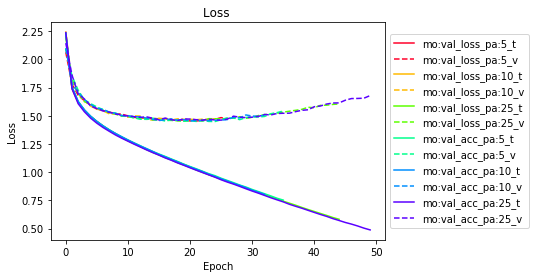

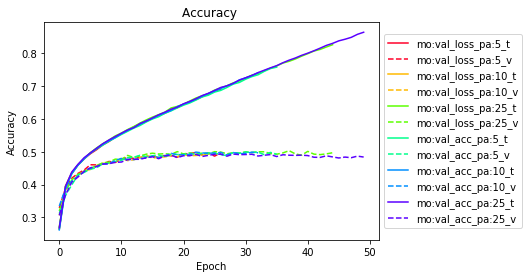

In [13]:
plot_data(results)

code map:{'monitor': 'mo', 'patience': 'pa'}


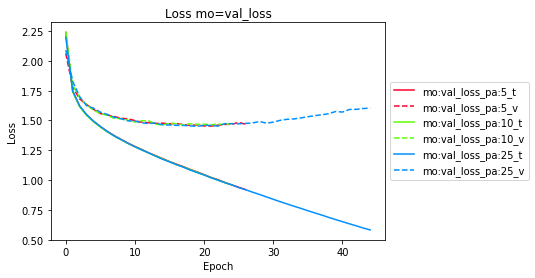

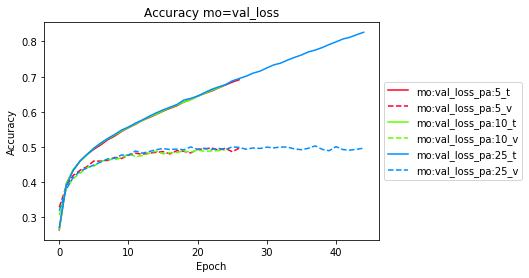


code map:{'monitor': 'mo', 'patience': 'pa'}


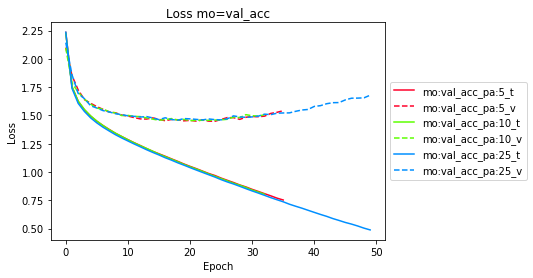

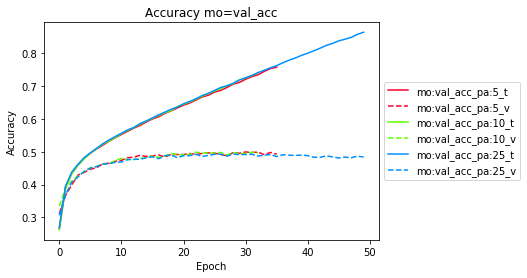

In [14]:
for monitor in opts_earlystop_monitor:
    results_by_key = {k: v for k, v in results.items() if f'{opts_abbr[KEY_EARLYSTOP_MONITOR]}:{monitor}' in k}
    plot_data(results_by_key, title=f'{opts_abbr[KEY_EARLYSTOP_MONITOR]}={monitor}')

code map:{'monitor': 'mo', 'patience': 'pa'}


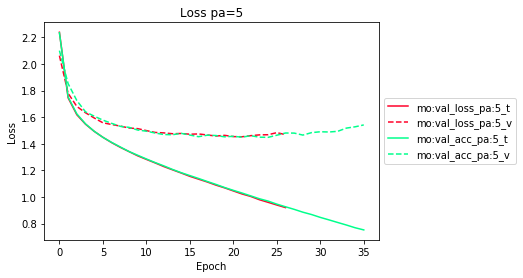

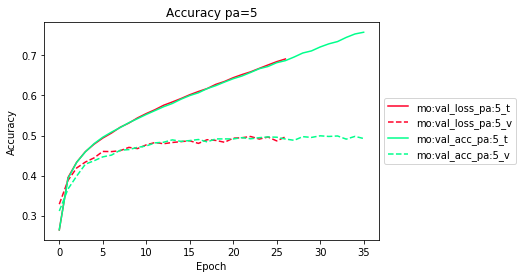


code map:{'monitor': 'mo', 'patience': 'pa'}


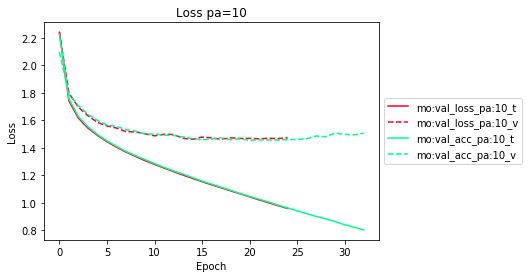

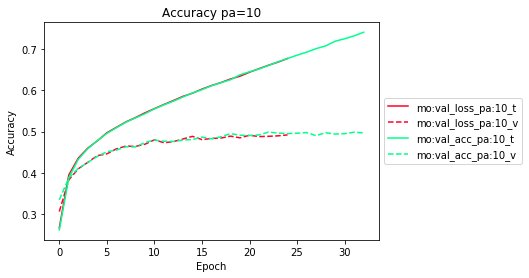


code map:{'monitor': 'mo', 'patience': 'pa'}


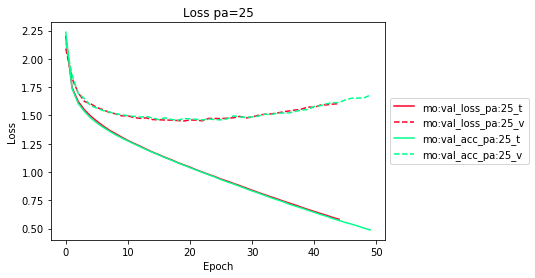

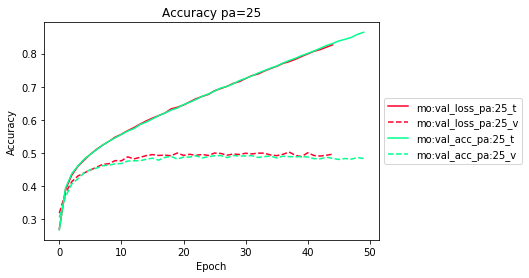

In [15]:
for patience in opts_earlystop_patience:
    results_by_key = {k: v for k, v in results.items() if f'{opts_abbr[KEY_EARLYSTOP_PATIENCE]}:{patience}' in k}
    plot_data(results_by_key, title=f'{opts_abbr[KEY_EARLYSTOP_PATIENCE]}={patience}')